# GDSCv2 Interpretation

This notebook shows some example on how to interpret the output from the Bayesian model to infer responses of basket/cluster combinations.

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

sys.path.append('..')
sys.path.append('.')

In [3]:
from pyBasket.common import load_obj
from pyBasket.interpret import get_predicted_basket_df, get_basket_cluster_prob_df, find_top_k_indices, find_bottom_k_indices
from pyBasket.interpret import select_partition, plot_responsive_count, get_member_expression, ttest_dataframe
from pyBasket.interpret import plot_expression_boxplot, df_diff, plot_basket_probs, plot_basket_cluster_heatmap
from pyBasket.clustering import plot_PCA

# Load results

Load previously saved results

In [4]:
drug_name = 'Erlotinib'
C = 5

In [5]:
input_dir = 'results'
file_name = 'patient_analysis_%s_cluster_%d.p' % (drug_name, C)
save_data = load_obj(os.path.join(input_dir, file_name))

In [6]:
list(save_data.keys())

['expr_df_filtered',
 'expr_df_selected',
 'drug_response',
 'class_labels',
 'cluster_labels',
 'patient_df',
 'stacked_posterior',
 'trace',
 'importance_df']

# Things to show in the viz

## Basket probabilities

In [7]:
predicted_basket_df = get_predicted_basket_df(save_data)
predicted_basket_df

,prob
Biliary Tract,0.717905
Bladder/Urinary Tract,0.750173
Bone,0.682868
Bowel,0.732052
Breast,0.710906
Cervix,0.201092
CNS/Brain,0.807991
Esophagus/Stomach,0.693657
Head and Neck,0.081071
Kidney,0.363568


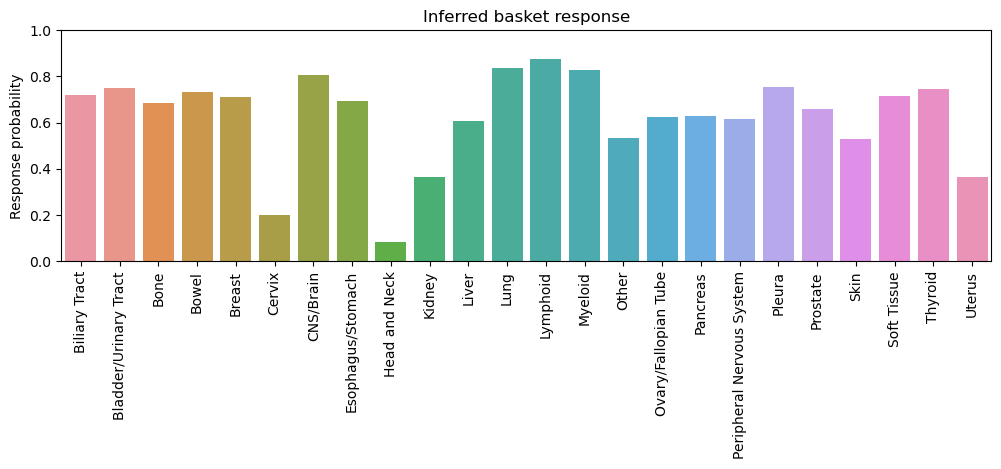

In [8]:
plot_basket_probs(predicted_basket_df)

## Overall heatmap

In [9]:
inferred_df = get_basket_cluster_prob_df(save_data)

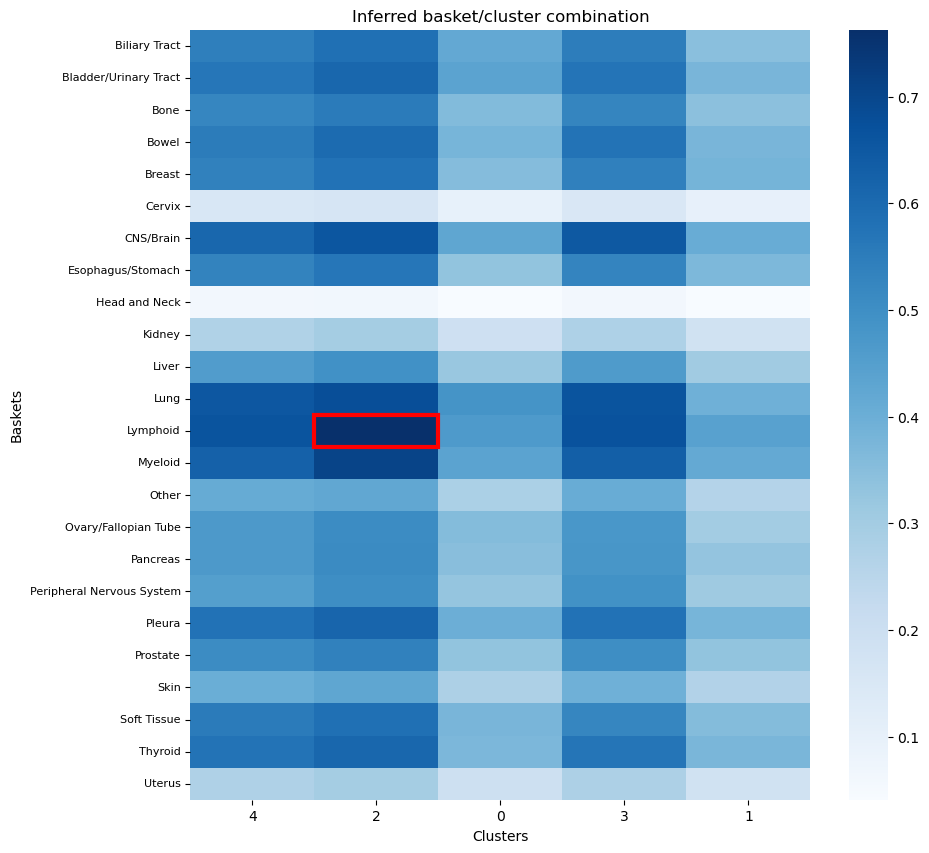

In [10]:
plot_basket_cluster_heatmap(inferred_df, 1, 12)

# Any interesting data to look at?

## Which basket/cluster combinations have the highest / lowest response rates?

In [11]:
top_df = find_top_k_indices(save_data, 10)
top_df

,basket_idx,cluster_idx,basket,cluster,probability,count
0,12,1,Lymphoid,2,0.762703,0
1,13,1,Myeloid,2,0.708056,0
2,11,1,Lung,2,0.679652,3
3,12,3,Lymphoid,3,0.667976,0
4,12,0,Lymphoid,4,0.662015,0
5,11,3,Lung,3,0.661513,15
6,6,1,CNS/Brain,2,0.657786,0
7,11,0,Lung,4,0.653129,4
8,6,3,CNS/Brain,3,0.647748,2
9,13,3,Myeloid,3,0.630855,0


In [12]:
bottom_df = find_bottom_k_indices(save_data, 10)
bottom_df

,basket_idx,cluster_idx,basket,cluster,probability,count
0,8,4,Head and Neck,1,0.040923,0
1,8,2,Head and Neck,0,0.040978,4
2,8,0,Head and Neck,4,0.061005,0
3,8,3,Head and Neck,3,0.061875,0
4,8,1,Head and Neck,2,0.065931,12
5,5,2,Cervix,0,0.099388,3
6,5,4,Cervix,1,0.100359,0
7,5,3,Cervix,3,0.151729,2
8,5,0,Cervix,4,0.154026,1
9,5,1,Cervix,2,0.163600,7


## Inspect one partition

In [13]:
query_basket = 'Lung'
query_cluster = 3
selected_df = select_partition(save_data, query_basket, query_cluster)
selected_df

,tissues,responses,basket_number,cluster_number,responsive
samples,,,,,
NCI-H847,Lung,0.099518,11,3,0
CPC-N,Lung,0.004777,11,3,1
NCI-H835,Lung,0.000000,11,3,1
NCI-H720,Lung,0.029633,11,3,1
NCI-H1417,Lung,0.074547,11,3,0
COR-L32,Lung,0.000000,11,3,1
NCI-H2141,Lung,0.076941,11,3,0
NCI-H64,Lung,0.050909,11,3,1
SBC-3,Lung,0.032265,11,3,1


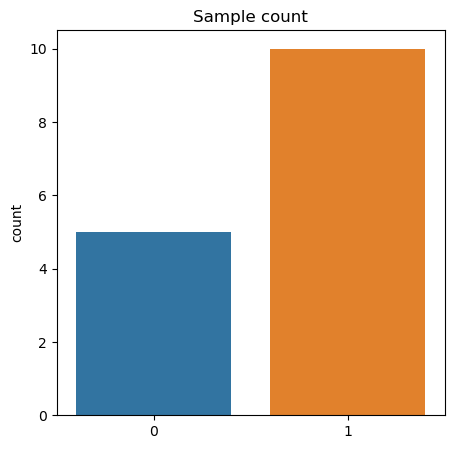

In [14]:
plot_responsive_count(selected_df)

In [15]:
member_df = get_member_expression(selected_df, save_data)
member_df.shape

(15, 500)

PCA explained variance [0.18505025 0.34084422]


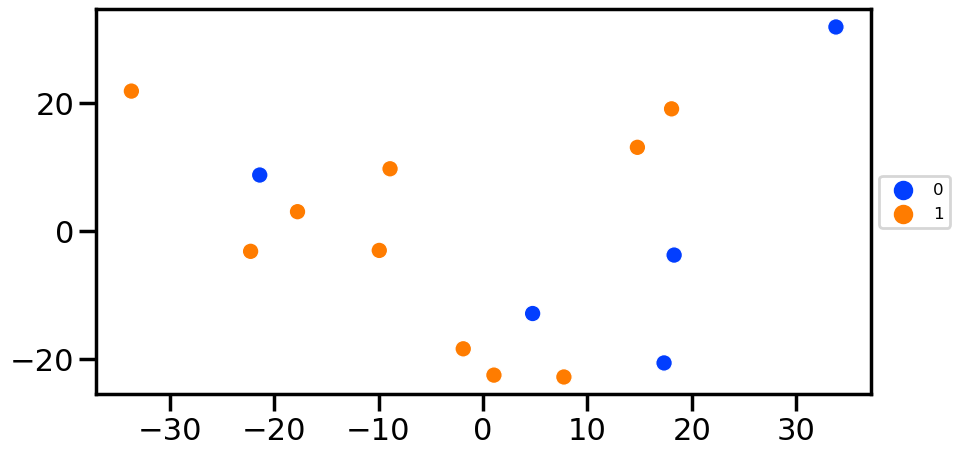

In [16]:
pc1, pc2 = plot_PCA(member_df, hue=selected_df['responsive'], n_components=2)

Pick the first transcript as it has the highest importance score during feature selection.

In [17]:
all_expr_df = df_diff(member_df, save_data['expr_df_selected'])
all_expr_df.shape

(283, 500)

In [18]:
test_df = ttest_dataframe(member_df, all_expr_df, only_significant=True)
test_df

,T-Statistic,P-Value,P-Value (Bonferroni),Significant
Feature,,,,
ENSG00000198785.7,9.821224,6.860107e-20,3.430054e-17,True
ENSG00000166111.10,9.481253,8.540863e-19,4.270431e-16,True
ENSG00000243364.8,-9.199744,6.657083e-18,3.328542e-15,True
ENSG00000095059.16,7.604168,3.827110e-13,1.913555e-10,True
ENSG00000168243.11,7.251744,3.612122e-12,1.806061e-09,True
ENSG00000136352.17,7.158538,6.463687e-12,3.231844e-09,True
ENSG00000176102.13,7.095781,9.536851e-12,4.768426e-09,True
ENSG00000043514.17,7.015240,1.565777e-11,7.828886e-09,True
ENSG00000101746.15,6.901147,3.139724e-11,1.569862e-08,True


In [19]:
selected_feature = test_df.index.values[0]
selected_feature

'ENSG00000198785.7'

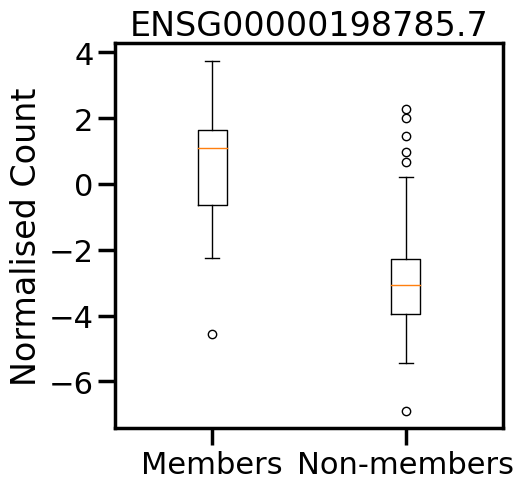

In [20]:
plot_expression_boxplot(selected_feature, member_df, all_expr_df)